In [1]:
%%capture
!pip install -e ./lib/mei;

## Restart Kernel after mei-module installation!

In [1]:
import torch
import numpy as np
import pandas as pd
import mei.legacy
import matplotlib.pyplot as plt
import seaborn as sns
import sensorium
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from nnfabrik.builder import get_data, get_model
from gradient_ascent import gradient_ascent
from sensorium.utility import get_signal_correlations
from sensorium.utility.measure_helpers import get_df_for_scores

In [2]:
seed=31415
data_key_aut = "29027-6-17-1-6-5"
data_key_wt = "29028-1-17-1-6-5"
data_key_sens2 = "23964-4-22"
autistic_mouse_dataPath = "../data/new_data2023/static29027-6-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
wildtype_mouse_dataPath = "../data/new_data2023/static29028-1-17-1-6-5-GrayImageNetFrame2-7bed7f7379d99271be5d144e5e59a8e7.zip"
sens2_dataPath = "../data/sensorium_data2022/static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"

In [3]:
dataset_fn = 'sensorium.datasets.static_loaders'

filenames_autistic = [autistic_mouse_dataPath, ]

dataset_config_autistic = {'paths': filenames_autistic,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':1,
                 }

dataloaders_autistic = get_data(dataset_fn, dataset_config_autistic)

filenames_wildtype = [wildtype_mouse_dataPath, ]

dataset_config_wildtype = {'paths': filenames_wildtype,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':1,
                 }

dataloaders_wildtype = get_data(dataset_fn, dataset_config_wildtype)

filenames_sens2 = [sens2_dataPath, ]

dataset_config_sens2 = {'paths': filenames_sens2,
                 'normalize': True,
                 'include_behavior': False,
                 'include_eye_position': False,
                 'batch_size': 128,
                 'scale':0.25,
                 }

dataloaders_sens2 = get_data(dataset_fn, dataset_config_sens2)

In [4]:
model_fn = 'sensorium.models.stacked_core_full_gauss_readout'
model_config = {'pad_input': False,
  'stack': -1,
  'layers': 4,
  'input_kern': 9,
  'gamma_input': 6.3831,
  'gamma_readout': 0.0076,
  'hidden_kern': 7,
  'hidden_channels': 64,
  'depth_separable': True,
  'grid_mean_predictor': {'type': 'cortex',
   'input_dimensions': 2,
   'hidden_layers': 1,
   'hidden_features': 30,
   'final_tanh': True},
  'init_sigma': 0.1,
  'init_mu_range': 0.3,
  'gauss_type': 'full',
  'shifter': False,
}

model_a = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_autistic,
                  seed=seed,
                  )
model_wt = get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_wildtype,
                  seed=seed,
                  )

model_sens2= get_model(model_fn=model_fn,
                  model_config=model_config,
                  dataloaders=dataloaders_sens2,
                  seed=seed,
                  )

In [5]:
model_a.load_state_dict(torch.load("./model_checkpoints/autistic_model.pth"))
model_wt.load_state_dict(torch.load("./model_checkpoints/wildtype_model.pth"))
model_sens2.load_state_dict(torch.load("./model_checkpoints/sensorium23964-4-22.pth"))

<All keys matched successfully>

In [6]:
model_a.eval()
model_wt.eval()
model_sens2.eval()

FiringRateEncoder(
  (core): Stacked2dCore(
    (_input_weights_regularizer): LaplaceL2norm(
      (laplace): Laplace()
    )
    (features): Sequential(
      (layer0): Sequential(
        (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer1): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (spatial_conv): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=64, bias=False)
          (out_depth_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
        (nonlin): AdaptiveELU()
      )
      (layer2): Sequential(
        (ds_conv): DepthSeparableConv2d(
          (in_depth_conv): 

In [7]:
correlation_to_average_a = get_signal_correlations(model_a, dataloaders_autistic, tier="test", device="cuda", as_dict=True)
correlation_to_average_wt = get_signal_correlations(model_wt, dataloaders_wildtype, tier="test", device="cuda", as_dict=True)
correlation_to_average_s2 = get_signal_correlations(model_sens2, dataloaders_sens2, tier="test", device="cuda", as_dict=True)

df_cta_a = get_df_for_scores(session_dict=correlation_to_average_a, measure_attribute="Correlation to Average")
df_cta_wt = get_df_for_scores(session_dict=correlation_to_average_wt, measure_attribute="Correlation to Average")
df_cta_s2 = get_df_for_scores(session_dict=correlation_to_average_s2, measure_attribute="Correlation to Average")

In [8]:
top200units_a = df_cta_a.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
top200units_wt = df_cta_wt.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()
top200units_s2 = df_cta_s2.sort_values(["Correlation to Average"], ascending=False).reset_index()[:200]["index"].to_list()

In [9]:
config = dict(
    initial={"path": "mei.initial.RandomNormal"},
    optimizer={"path": "torch.optim.SGD", "kwargs": {"lr": 1}},
    precondition={"path": "mei.legacy.ops.GaussianBlur", "kwargs": {"sigma": 1}},
    postprocessing={"path": "mei.legacy.ops.ChangeNorm", "kwargs": {"norm": 7.5}},
    transparency_weight=0.0,
    stopper={"path": "mei.stoppers.NumIterations", "kwargs": {"num_iterations": 1000}},
    objectives=[
        {"path": "mei.objectives.EvaluationObjective", "kwargs": {"interval": 10}}
    ],
    device="cuda"
)

In [10]:
meis_a = []
for i in tqdm(top200units_a):
    mei_a, _, _ = gradient_ascent(model_a, config, data_key=data_key_aut, unit=i, seed=seed, shape=(1,1,36,64))
    meis_a.append(mei_a)
torch.save(meis_a, "MEIs/meis_a200.pt")

  0%|          | 0/200 [00:00<?, ?it/s]

Using a transparency weight of 0.0


  0%|          | 1/200 [00:21<1:09:52, 21.07s/it]

Using a transparency weight of 0.0


  1%|          | 2/200 [00:41<1:09:20, 21.01s/it]

Using a transparency weight of 0.0


  2%|▏         | 3/200 [01:03<1:09:36, 21.20s/it]

Using a transparency weight of 0.0


  2%|▏         | 4/200 [01:24<1:09:22, 21.24s/it]

Using a transparency weight of 0.0


  2%|▎         | 5/200 [01:45<1:08:16, 21.01s/it]

Using a transparency weight of 0.0


  3%|▎         | 6/200 [02:05<1:07:25, 20.85s/it]

Using a transparency weight of 0.0


  4%|▎         | 7/200 [02:27<1:07:48, 21.08s/it]

Using a transparency weight of 0.0


  4%|▍         | 8/200 [02:48<1:07:04, 20.96s/it]

Using a transparency weight of 0.0


  4%|▍         | 9/200 [03:08<1:06:29, 20.89s/it]

Using a transparency weight of 0.0


  5%|▌         | 10/200 [03:29<1:05:56, 20.82s/it]

Using a transparency weight of 0.0


  6%|▌         | 11/200 [03:50<1:05:29, 20.79s/it]

Using a transparency weight of 0.0


  6%|▌         | 12/200 [04:10<1:05:01, 20.75s/it]

Using a transparency weight of 0.0


  6%|▋         | 13/200 [04:31<1:04:36, 20.73s/it]

Using a transparency weight of 0.0


  7%|▋         | 14/200 [04:52<1:04:13, 20.72s/it]

Using a transparency weight of 0.0


  8%|▊         | 15/200 [05:13<1:04:25, 20.89s/it]

Using a transparency weight of 0.0


  8%|▊         | 16/200 [05:34<1:03:47, 20.80s/it]

Using a transparency weight of 0.0


  8%|▊         | 17/200 [05:54<1:03:12, 20.72s/it]

Using a transparency weight of 0.0


  9%|▉         | 18/200 [06:15<1:02:39, 20.66s/it]

Using a transparency weight of 0.0


 10%|▉         | 19/200 [06:35<1:02:14, 20.63s/it]

Using a transparency weight of 0.0


 10%|█         | 20/200 [06:56<1:02:21, 20.79s/it]

Using a transparency weight of 0.0


 10%|█         | 21/200 [07:18<1:03:00, 21.12s/it]

Using a transparency weight of 0.0


 11%|█         | 22/200 [07:40<1:03:16, 21.33s/it]

Using a transparency weight of 0.0


 12%|█▏        | 23/200 [08:02<1:03:17, 21.45s/it]

Using a transparency weight of 0.0


 12%|█▏        | 24/200 [08:24<1:03:23, 21.61s/it]

Using a transparency weight of 0.0


 12%|█▎        | 25/200 [08:45<1:02:46, 21.52s/it]

Using a transparency weight of 0.0


 13%|█▎        | 26/200 [09:06<1:02:00, 21.38s/it]

Using a transparency weight of 0.0


 14%|█▎        | 27/200 [09:27<1:01:28, 21.32s/it]

Using a transparency weight of 0.0


 14%|█▍        | 28/200 [09:49<1:00:53, 21.24s/it]

Using a transparency weight of 0.0


 14%|█▍        | 29/200 [10:10<1:01:03, 21.43s/it]

Using a transparency weight of 0.0


 15%|█▌        | 30/200 [10:32<1:00:41, 21.42s/it]

Using a transparency weight of 0.0


 16%|█▌        | 31/200 [10:53<1:00:27, 21.46s/it]

Using a transparency weight of 0.0


 16%|█▌        | 32/200 [11:15<1:00:16, 21.52s/it]

Using a transparency weight of 0.0


 16%|█▋        | 33/200 [11:36<59:46, 21.48s/it]  

Using a transparency weight of 0.0


 17%|█▋        | 34/200 [11:58<59:16, 21.43s/it]

Using a transparency weight of 0.0


 18%|█▊        | 35/200 [12:19<58:47, 21.38s/it]

Using a transparency weight of 0.0


 18%|█▊        | 36/200 [12:40<58:15, 21.31s/it]

Using a transparency weight of 0.0


 18%|█▊        | 37/200 [13:01<57:30, 21.17s/it]

Using a transparency weight of 0.0


 19%|█▉        | 38/200 [13:22<56:47, 21.03s/it]

Using a transparency weight of 0.0


 20%|█▉        | 39/200 [13:42<56:09, 20.93s/it]

Using a transparency weight of 0.0


 20%|██        | 40/200 [14:03<55:36, 20.86s/it]

Using a transparency weight of 0.0


 20%|██        | 41/200 [14:24<55:07, 20.80s/it]

Using a transparency weight of 0.0


 21%|██        | 42/200 [14:44<54:45, 20.80s/it]

Using a transparency weight of 0.0


 22%|██▏       | 43/200 [15:05<54:19, 20.76s/it]

Using a transparency weight of 0.0


 22%|██▏       | 44/200 [15:26<53:49, 20.70s/it]

Using a transparency weight of 0.0


 22%|██▎       | 45/200 [15:46<53:24, 20.67s/it]

Using a transparency weight of 0.0


 23%|██▎       | 46/200 [16:07<53:02, 20.66s/it]

Using a transparency weight of 0.0


 24%|██▎       | 47/200 [16:28<53:19, 20.92s/it]

Using a transparency weight of 0.0


 24%|██▍       | 48/200 [16:50<53:21, 21.06s/it]

Using a transparency weight of 0.0


 24%|██▍       | 49/200 [17:11<53:14, 21.16s/it]

Using a transparency weight of 0.0


 25%|██▌       | 50/200 [17:33<53:07, 21.25s/it]

Using a transparency weight of 0.0


 26%|██▌       | 51/200 [17:54<52:59, 21.34s/it]

Using a transparency weight of 0.0


 26%|██▌       | 52/200 [18:16<52:46, 21.40s/it]

Using a transparency weight of 0.0


 26%|██▋       | 53/200 [18:37<52:25, 21.40s/it]

Using a transparency weight of 0.0


 27%|██▋       | 54/200 [18:59<52:09, 21.44s/it]

Using a transparency weight of 0.0


 28%|██▊       | 55/200 [19:20<51:47, 21.43s/it]

Using a transparency weight of 0.0


 28%|██▊       | 56/200 [19:42<51:32, 21.47s/it]

Using a transparency weight of 0.0


 28%|██▊       | 57/200 [20:03<51:09, 21.47s/it]

Using a transparency weight of 0.0


 29%|██▉       | 58/200 [20:24<50:33, 21.36s/it]

Using a transparency weight of 0.0


 30%|██▉       | 59/200 [20:45<49:44, 21.17s/it]

Using a transparency weight of 0.0


 30%|███       | 60/200 [21:06<49:04, 21.03s/it]

Using a transparency weight of 0.0


 30%|███       | 61/200 [21:26<48:32, 20.95s/it]

Using a transparency weight of 0.0


 31%|███       | 62/200 [21:47<47:54, 20.83s/it]

Using a transparency weight of 0.0


 32%|███▏      | 63/200 [22:08<47:19, 20.73s/it]

Using a transparency weight of 0.0


 32%|███▏      | 64/200 [22:28<46:50, 20.67s/it]

Using a transparency weight of 0.0


 32%|███▎      | 65/200 [22:48<46:19, 20.59s/it]

Using a transparency weight of 0.0


 33%|███▎      | 66/200 [23:09<45:51, 20.53s/it]

Using a transparency weight of 0.0


 34%|███▎      | 67/200 [23:30<45:39, 20.60s/it]

Using a transparency weight of 0.0


 34%|███▍      | 68/200 [23:51<46:06, 20.96s/it]

Using a transparency weight of 0.0


 34%|███▍      | 69/200 [24:13<46:13, 21.17s/it]

Using a transparency weight of 0.0


 35%|███▌      | 70/200 [24:35<46:10, 21.31s/it]

Using a transparency weight of 0.0


 36%|███▌      | 71/200 [24:56<45:55, 21.36s/it]

Using a transparency weight of 0.0


 36%|███▌      | 72/200 [25:18<45:34, 21.37s/it]

Using a transparency weight of 0.0


 36%|███▋      | 73/200 [25:39<45:21, 21.43s/it]

Using a transparency weight of 0.0


 37%|███▋      | 74/200 [26:01<44:58, 21.42s/it]

Using a transparency weight of 0.0


 38%|███▊      | 75/200 [26:22<44:47, 21.50s/it]

Using a transparency weight of 0.0


 38%|███▊      | 76/200 [26:43<43:59, 21.29s/it]

Using a transparency weight of 0.0


 38%|███▊      | 77/200 [27:04<43:14, 21.10s/it]

Using a transparency weight of 0.0


 39%|███▉      | 78/200 [27:26<43:21, 21.33s/it]

Using a transparency weight of 0.0


 40%|███▉      | 79/200 [27:47<43:05, 21.37s/it]

Using a transparency weight of 0.0


 40%|████      | 80/200 [28:08<42:44, 21.37s/it]

Using a transparency weight of 0.0


 40%|████      | 81/200 [28:30<42:25, 21.39s/it]

Using a transparency weight of 0.0


 41%|████      | 82/200 [28:51<42:05, 21.40s/it]

Using a transparency weight of 0.0


 42%|████▏     | 83/200 [29:13<41:53, 21.48s/it]

Using a transparency weight of 0.0


 42%|████▏     | 84/200 [29:34<41:33, 21.49s/it]

Using a transparency weight of 0.0


 42%|████▎     | 85/200 [29:56<41:13, 21.51s/it]

Using a transparency weight of 0.0


 43%|████▎     | 86/200 [30:17<40:41, 21.42s/it]

Using a transparency weight of 0.0


 44%|████▎     | 87/200 [30:39<40:43, 21.63s/it]

Using a transparency weight of 0.0


 44%|████▍     | 88/200 [31:00<39:55, 21.39s/it]

Using a transparency weight of 0.0


 44%|████▍     | 89/200 [31:21<39:05, 21.13s/it]

Using a transparency weight of 0.0


 45%|████▌     | 90/200 [31:41<38:21, 20.93s/it]

Using a transparency weight of 0.0


 46%|████▌     | 91/200 [32:02<37:47, 20.81s/it]

Using a transparency weight of 0.0


 46%|████▌     | 92/200 [32:23<37:41, 20.94s/it]

Using a transparency weight of 0.0


 46%|████▋     | 93/200 [32:44<37:13, 20.87s/it]

Using a transparency weight of 0.0


 47%|████▋     | 94/200 [33:04<36:42, 20.78s/it]

Using a transparency weight of 0.0


 48%|████▊     | 95/200 [33:25<36:19, 20.75s/it]

Using a transparency weight of 0.0


 48%|████▊     | 96/200 [33:46<35:56, 20.73s/it]

Using a transparency weight of 0.0


 48%|████▊     | 97/200 [34:07<35:43, 20.81s/it]

Using a transparency weight of 0.0


 49%|████▉     | 98/200 [34:27<35:19, 20.78s/it]

Using a transparency weight of 0.0


 50%|████▉     | 99/200 [34:48<34:57, 20.77s/it]

Using a transparency weight of 0.0


 50%|█████     | 100/200 [35:09<34:31, 20.71s/it]

Using a transparency weight of 0.0


 50%|█████     | 101/200 [35:29<34:04, 20.65s/it]

Using a transparency weight of 0.0


 51%|█████     | 102/200 [35:50<33:44, 20.66s/it]

Using a transparency weight of 0.0


 52%|█████▏    | 103/200 [36:10<33:20, 20.63s/it]

Using a transparency weight of 0.0


 52%|█████▏    | 104/200 [36:31<33:04, 20.67s/it]

Using a transparency weight of 0.0


 52%|█████▎    | 105/200 [36:52<32:40, 20.63s/it]

Using a transparency weight of 0.0


 53%|█████▎    | 106/200 [37:12<32:16, 20.60s/it]

Using a transparency weight of 0.0


 54%|█████▎    | 107/200 [37:33<32:00, 20.65s/it]

Using a transparency weight of 0.0


 54%|█████▍    | 108/200 [37:54<31:55, 20.82s/it]

Using a transparency weight of 0.0


 55%|█████▍    | 109/200 [38:16<31:52, 21.02s/it]

Using a transparency weight of 0.0


 55%|█████▌    | 110/200 [38:37<31:45, 21.17s/it]

Using a transparency weight of 0.0


 56%|█████▌    | 111/200 [38:59<31:32, 21.27s/it]

Using a transparency weight of 0.0


 56%|█████▌    | 112/200 [39:20<31:15, 21.31s/it]

Using a transparency weight of 0.0


 56%|█████▋    | 113/200 [39:41<30:57, 21.35s/it]

Using a transparency weight of 0.0


 57%|█████▋    | 114/200 [40:03<30:35, 21.35s/it]

Using a transparency weight of 0.0


 57%|█████▊    | 115/200 [40:24<30:16, 21.37s/it]

Using a transparency weight of 0.0


 58%|█████▊    | 116/200 [40:46<29:57, 21.39s/it]

Using a transparency weight of 0.0


 58%|█████▊    | 117/200 [41:07<29:36, 21.40s/it]

Using a transparency weight of 0.0


 59%|█████▉    | 118/200 [41:28<29:14, 21.40s/it]

Using a transparency weight of 0.0


 60%|█████▉    | 119/200 [41:50<28:56, 21.44s/it]

Using a transparency weight of 0.0


 60%|██████    | 120/200 [42:11<28:34, 21.43s/it]

Using a transparency weight of 0.0


 60%|██████    | 121/200 [42:33<28:12, 21.43s/it]

Using a transparency weight of 0.0


 61%|██████    | 122/200 [42:54<27:50, 21.42s/it]

Using a transparency weight of 0.0


 62%|██████▏   | 123/200 [43:16<27:28, 21.40s/it]

Using a transparency weight of 0.0


 62%|██████▏   | 124/200 [43:37<27:05, 21.39s/it]

Using a transparency weight of 0.0


 62%|██████▎   | 125/200 [43:58<26:45, 21.40s/it]

Using a transparency weight of 0.0


 63%|██████▎   | 126/200 [44:20<26:23, 21.39s/it]

Using a transparency weight of 0.0


 64%|██████▎   | 127/200 [44:41<25:58, 21.35s/it]

Using a transparency weight of 0.0


 64%|██████▍   | 128/200 [45:02<25:37, 21.35s/it]

Using a transparency weight of 0.0


 64%|██████▍   | 129/200 [45:24<25:15, 21.34s/it]

Using a transparency weight of 0.0


 65%|██████▌   | 130/200 [45:45<24:52, 21.32s/it]

Using a transparency weight of 0.0


 66%|██████▌   | 131/200 [46:06<24:31, 21.33s/it]

Using a transparency weight of 0.0


 66%|██████▌   | 132/200 [46:28<24:24, 21.54s/it]

Using a transparency weight of 0.0


 66%|██████▋   | 133/200 [46:51<24:19, 21.78s/it]

Using a transparency weight of 0.0


 67%|██████▋   | 134/200 [47:12<23:51, 21.68s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 135/200 [47:34<23:41, 21.87s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 136/200 [47:57<23:28, 22.01s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 137/200 [48:19<23:03, 21.96s/it]

Using a transparency weight of 0.0


 69%|██████▉   | 138/200 [48:41<22:39, 21.93s/it]

Using a transparency weight of 0.0


 70%|██████▉   | 139/200 [49:03<22:19, 21.95s/it]

Using a transparency weight of 0.0


 70%|███████   | 140/200 [49:25<22:05, 22.08s/it]

Using a transparency weight of 0.0


 70%|███████   | 141/200 [49:47<21:36, 21.97s/it]

Using a transparency weight of 0.0


 71%|███████   | 142/200 [50:08<21:09, 21.89s/it]

Using a transparency weight of 0.0


 72%|███████▏  | 143/200 [50:30<20:46, 21.87s/it]

Using a transparency weight of 0.0


 72%|███████▏  | 144/200 [50:52<20:19, 21.77s/it]

Using a transparency weight of 0.0


 72%|███████▎  | 145/200 [51:13<19:57, 21.77s/it]

Using a transparency weight of 0.0


 73%|███████▎  | 146/200 [51:35<19:33, 21.73s/it]

Using a transparency weight of 0.0


 74%|███████▎  | 147/200 [51:57<19:12, 21.75s/it]

Using a transparency weight of 0.0


 74%|███████▍  | 148/200 [52:19<18:53, 21.80s/it]

Using a transparency weight of 0.0


 74%|███████▍  | 149/200 [52:41<18:33, 21.84s/it]

Using a transparency weight of 0.0


 75%|███████▌  | 150/200 [53:03<18:16, 21.92s/it]

Using a transparency weight of 0.0


 76%|███████▌  | 151/200 [53:25<17:52, 21.90s/it]

Using a transparency weight of 0.0


 76%|███████▌  | 152/200 [53:46<17:30, 21.88s/it]

Using a transparency weight of 0.0


 76%|███████▋  | 153/200 [54:08<17:02, 21.75s/it]

Using a transparency weight of 0.0


 77%|███████▋  | 154/200 [54:30<16:41, 21.76s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 155/200 [54:52<16:27, 21.95s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 156/200 [55:14<15:58, 21.79s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 157/200 [55:35<15:34, 21.73s/it]

Using a transparency weight of 0.0


 79%|███████▉  | 158/200 [55:57<15:20, 21.91s/it]

Using a transparency weight of 0.0


 80%|███████▉  | 159/200 [56:19<14:55, 21.85s/it]

Using a transparency weight of 0.0


 80%|████████  | 160/200 [56:41<14:27, 21.70s/it]

Using a transparency weight of 0.0


 80%|████████  | 161/200 [57:03<14:10, 21.81s/it]

Using a transparency weight of 0.0


 81%|████████  | 162/200 [57:24<13:44, 21.70s/it]

Using a transparency weight of 0.0


 82%|████████▏ | 163/200 [57:46<13:25, 21.77s/it]

Using a transparency weight of 0.0


 82%|████████▏ | 164/200 [58:08<13:06, 21.85s/it]

Using a transparency weight of 0.0


 82%|████████▎ | 165/200 [58:30<12:50, 22.02s/it]

Using a transparency weight of 0.0


 83%|████████▎ | 166/200 [58:53<12:31, 22.10s/it]

Using a transparency weight of 0.0


 84%|████████▎ | 167/200 [59:14<12:05, 21.99s/it]

Using a transparency weight of 0.0


 84%|████████▍ | 168/200 [59:37<11:45, 22.04s/it]

Using a transparency weight of 0.0


 84%|████████▍ | 169/200 [59:58<11:21, 21.99s/it]

Using a transparency weight of 0.0


 85%|████████▌ | 170/200 [1:00:21<11:03, 22.13s/it]

Using a transparency weight of 0.0


 86%|████████▌ | 171/200 [1:00:43<10:39, 22.06s/it]

Using a transparency weight of 0.0


 86%|████████▌ | 172/200 [1:01:05<10:16, 22.01s/it]

Using a transparency weight of 0.0


 86%|████████▋ | 173/200 [1:01:27<09:52, 21.96s/it]

Using a transparency weight of 0.0


 87%|████████▋ | 174/200 [1:01:48<09:30, 21.93s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 175/200 [1:02:10<09:03, 21.75s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 176/200 [1:02:31<08:35, 21.48s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 177/200 [1:02:53<08:22, 21.83s/it]

Using a transparency weight of 0.0


 89%|████████▉ | 178/200 [1:03:17<08:11, 22.36s/it]

Using a transparency weight of 0.0


 90%|████████▉ | 179/200 [1:03:40<07:56, 22.71s/it]

Using a transparency weight of 0.0


 90%|█████████ | 180/200 [1:04:05<07:43, 23.19s/it]

Using a transparency weight of 0.0


 90%|█████████ | 181/200 [1:04:27<07:13, 22.84s/it]

Using a transparency weight of 0.0


 91%|█████████ | 182/200 [1:04:51<06:58, 23.25s/it]

Using a transparency weight of 0.0


 92%|█████████▏| 183/200 [1:05:14<06:33, 23.14s/it]

Using a transparency weight of 0.0


 92%|█████████▏| 184/200 [1:05:35<06:02, 22.67s/it]

Using a transparency weight of 0.0


 92%|█████████▎| 185/200 [1:05:57<05:36, 22.45s/it]

Using a transparency weight of 0.0


 93%|█████████▎| 186/200 [1:06:19<05:09, 22.14s/it]

Using a transparency weight of 0.0


 94%|█████████▎| 187/200 [1:06:41<04:47, 22.13s/it]

Using a transparency weight of 0.0


 94%|█████████▍| 188/200 [1:07:02<04:23, 21.95s/it]

Using a transparency weight of 0.0


 94%|█████████▍| 189/200 [1:07:25<04:03, 22.12s/it]

Using a transparency weight of 0.0


 95%|█████████▌| 190/200 [1:07:46<03:38, 21.82s/it]

Using a transparency weight of 0.0


 96%|█████████▌| 191/200 [1:08:09<03:19, 22.14s/it]

Using a transparency weight of 0.0


 96%|█████████▌| 192/200 [1:08:30<02:55, 21.90s/it]

Using a transparency weight of 0.0


 96%|█████████▋| 193/200 [1:08:51<02:31, 21.59s/it]

Using a transparency weight of 0.0


 97%|█████████▋| 194/200 [1:09:12<02:09, 21.50s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 195/200 [1:09:36<01:50, 22.05s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 196/200 [1:09:58<01:28, 22.13s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 197/200 [1:10:20<01:06, 22.22s/it]

Using a transparency weight of 0.0


 99%|█████████▉| 198/200 [1:10:42<00:44, 22.09s/it]

Using a transparency weight of 0.0


100%|█████████▉| 199/200 [1:11:04<00:22, 22.08s/it]

Using a transparency weight of 0.0


100%|██████████| 200/200 [1:11:26<00:00, 21.43s/it]


In [11]:
meis_wt = []
for i in tqdm(top200units_wt):
    mei_wt, _, _ = gradient_ascent(model_wt, config, data_key=data_key_wt, unit=i, seed=seed, shape=(1,1,36,64))
    meis_wt.append(mei_wt)
torch.save(meis_wt, "MEIs/meis_wt200.pt")

  0%|          | 0/200 [00:00<?, ?it/s]

Using a transparency weight of 0.0


  0%|          | 1/200 [00:21<1:12:17, 21.79s/it]

Using a transparency weight of 0.0


  1%|          | 2/200 [00:43<1:11:35, 21.69s/it]

Using a transparency weight of 0.0


  2%|▏         | 3/200 [01:05<1:11:30, 21.78s/it]

Using a transparency weight of 0.0


  2%|▏         | 4/200 [01:26<1:10:50, 21.69s/it]

Using a transparency weight of 0.0


  2%|▎         | 5/200 [01:48<1:11:01, 21.86s/it]

Using a transparency weight of 0.0


  3%|▎         | 6/200 [02:10<1:10:43, 21.87s/it]

Using a transparency weight of 0.0


  4%|▎         | 7/200 [02:32<1:09:54, 21.73s/it]

Using a transparency weight of 0.0


  4%|▍         | 8/200 [02:54<1:10:27, 22.02s/it]

Using a transparency weight of 0.0


  4%|▍         | 9/200 [03:17<1:10:33, 22.16s/it]

Using a transparency weight of 0.0


  5%|▌         | 10/200 [03:41<1:11:43, 22.65s/it]

Using a transparency weight of 0.0


  6%|▌         | 11/200 [04:03<1:10:34, 22.40s/it]

Using a transparency weight of 0.0


  6%|▌         | 12/200 [04:25<1:10:00, 22.34s/it]

Using a transparency weight of 0.0


  6%|▋         | 13/200 [04:47<1:09:38, 22.35s/it]

Using a transparency weight of 0.0


  7%|▋         | 14/200 [05:09<1:08:57, 22.24s/it]

Using a transparency weight of 0.0


  8%|▊         | 15/200 [05:31<1:07:54, 22.02s/it]

Using a transparency weight of 0.0


  8%|▊         | 16/200 [05:53<1:07:29, 22.01s/it]

Using a transparency weight of 0.0


  8%|▊         | 17/200 [06:15<1:07:35, 22.16s/it]

Using a transparency weight of 0.0


  9%|▉         | 18/200 [06:37<1:07:14, 22.17s/it]

Using a transparency weight of 0.0


 10%|▉         | 19/200 [07:00<1:07:14, 22.29s/it]

Using a transparency weight of 0.0


 10%|█         | 20/200 [07:23<1:07:20, 22.44s/it]

Using a transparency weight of 0.0


 10%|█         | 21/200 [07:45<1:06:52, 22.42s/it]

Using a transparency weight of 0.0


 11%|█         | 22/200 [08:08<1:07:01, 22.59s/it]

Using a transparency weight of 0.0


 12%|█▏        | 23/200 [08:29<1:05:32, 22.22s/it]

Using a transparency weight of 0.0


 12%|█▏        | 24/200 [08:51<1:04:42, 22.06s/it]

Using a transparency weight of 0.0


 12%|█▎        | 25/200 [09:12<1:03:37, 21.82s/it]

Using a transparency weight of 0.0


 13%|█▎        | 26/200 [09:34<1:03:15, 21.81s/it]

Using a transparency weight of 0.0


 14%|█▎        | 27/200 [09:55<1:02:17, 21.60s/it]

Using a transparency weight of 0.0


 14%|█▍        | 28/200 [10:18<1:03:18, 22.08s/it]

Using a transparency weight of 0.0


 14%|█▍        | 29/200 [10:40<1:02:06, 21.79s/it]

Using a transparency weight of 0.0


 15%|█▌        | 30/200 [11:01<1:01:07, 21.57s/it]

Using a transparency weight of 0.0


 16%|█▌        | 31/200 [11:21<1:00:03, 21.32s/it]

Using a transparency weight of 0.0


 16%|█▌        | 32/200 [11:42<59:01, 21.08s/it]  

Using a transparency weight of 0.0


 16%|█▋        | 33/200 [12:04<59:31, 21.39s/it]

Using a transparency weight of 0.0


 17%|█▋        | 34/200 [12:27<1:00:08, 21.74s/it]

Using a transparency weight of 0.0


 18%|█▊        | 35/200 [12:48<59:52, 21.77s/it]  

Using a transparency weight of 0.0


 18%|█▊        | 36/200 [13:09<58:46, 21.50s/it]

Using a transparency weight of 0.0


 18%|█▊        | 37/200 [13:32<59:06, 21.76s/it]

Using a transparency weight of 0.0


 19%|█▉        | 38/200 [13:54<59:09, 21.91s/it]

Using a transparency weight of 0.0


 20%|█▉        | 39/200 [14:16<58:41, 21.87s/it]

Using a transparency weight of 0.0


 20%|██        | 40/200 [14:38<58:24, 21.90s/it]

Using a transparency weight of 0.0


 20%|██        | 41/200 [15:00<58:18, 22.00s/it]

Using a transparency weight of 0.0


 21%|██        | 42/200 [15:21<57:22, 21.79s/it]

Using a transparency weight of 0.0


 22%|██▏       | 43/200 [15:44<58:08, 22.22s/it]

Using a transparency weight of 0.0


 22%|██▏       | 44/200 [16:06<57:28, 22.11s/it]

Using a transparency weight of 0.0


 22%|██▎       | 45/200 [16:29<57:38, 22.31s/it]

Using a transparency weight of 0.0


 23%|██▎       | 46/200 [16:51<56:54, 22.17s/it]

Using a transparency weight of 0.0


 24%|██▎       | 47/200 [17:14<56:55, 22.32s/it]

Using a transparency weight of 0.0


 24%|██▍       | 48/200 [17:37<57:35, 22.74s/it]

Using a transparency weight of 0.0


 24%|██▍       | 49/200 [17:59<56:07, 22.30s/it]

Using a transparency weight of 0.0


 25%|██▌       | 50/200 [18:21<56:13, 22.49s/it]

Using a transparency weight of 0.0


 26%|██▌       | 51/200 [18:42<54:22, 21.90s/it]

Using a transparency weight of 0.0


 26%|██▌       | 52/200 [19:04<53:51, 21.83s/it]

Using a transparency weight of 0.0


 26%|██▋       | 53/200 [19:25<53:16, 21.75s/it]

Using a transparency weight of 0.0


 27%|██▋       | 54/200 [19:47<52:59, 21.78s/it]

Using a transparency weight of 0.0


 28%|██▊       | 55/200 [20:10<53:36, 22.18s/it]

Using a transparency weight of 0.0


 28%|██▊       | 56/200 [20:32<53:11, 22.16s/it]

Using a transparency weight of 0.0


 28%|██▊       | 57/200 [20:53<51:33, 21.64s/it]

Using a transparency weight of 0.0


 29%|██▉       | 58/200 [21:15<51:20, 21.69s/it]

Using a transparency weight of 0.0


 30%|██▉       | 59/200 [21:37<51:42, 22.00s/it]

Using a transparency weight of 0.0


 30%|███       | 60/200 [21:58<50:47, 21.77s/it]

Using a transparency weight of 0.0


 30%|███       | 61/200 [22:22<51:53, 22.40s/it]

Using a transparency weight of 0.0


 31%|███       | 62/200 [22:46<52:10, 22.69s/it]

Using a transparency weight of 0.0


 32%|███▏      | 63/200 [23:09<52:11, 22.85s/it]

Using a transparency weight of 0.0


 32%|███▏      | 64/200 [23:31<51:20, 22.65s/it]

Using a transparency weight of 0.0


 32%|███▎      | 65/200 [23:52<50:03, 22.25s/it]

Using a transparency weight of 0.0


 33%|███▎      | 66/200 [24:14<48:54, 21.90s/it]

Using a transparency weight of 0.0


 34%|███▎      | 67/200 [24:35<48:19, 21.80s/it]

Using a transparency weight of 0.0


 34%|███▍      | 68/200 [24:59<49:07, 22.33s/it]

Using a transparency weight of 0.0


 34%|███▍      | 69/200 [25:21<48:54, 22.40s/it]

Using a transparency weight of 0.0


 35%|███▌      | 70/200 [25:43<47:54, 22.11s/it]

Using a transparency weight of 0.0


 36%|███▌      | 71/200 [26:04<47:01, 21.87s/it]

Using a transparency weight of 0.0


 36%|███▌      | 72/200 [26:25<46:08, 21.63s/it]

Using a transparency weight of 0.0


 36%|███▋      | 73/200 [26:46<45:22, 21.44s/it]

Using a transparency weight of 0.0


 37%|███▋      | 74/200 [27:07<44:28, 21.18s/it]

Using a transparency weight of 0.0


 38%|███▊      | 75/200 [27:28<44:28, 21.35s/it]

Using a transparency weight of 0.0


 38%|███▊      | 76/200 [27:50<44:04, 21.32s/it]

Using a transparency weight of 0.0


 38%|███▊      | 77/200 [28:12<44:25, 21.67s/it]

Using a transparency weight of 0.0


 39%|███▉      | 78/200 [28:34<44:12, 21.74s/it]

Using a transparency weight of 0.0


 40%|███▉      | 79/200 [28:56<44:00, 21.82s/it]

Using a transparency weight of 0.0


 40%|████      | 80/200 [29:17<42:53, 21.44s/it]

Using a transparency weight of 0.0


 40%|████      | 81/200 [29:38<42:31, 21.44s/it]

Using a transparency weight of 0.0


 41%|████      | 82/200 [29:59<42:03, 21.38s/it]

Using a transparency weight of 0.0


 42%|████▏     | 83/200 [30:21<41:43, 21.40s/it]

Using a transparency weight of 0.0


 42%|████▏     | 84/200 [30:43<41:46, 21.61s/it]

Using a transparency weight of 0.0


 42%|████▎     | 85/200 [31:03<40:39, 21.22s/it]

Using a transparency weight of 0.0


 43%|████▎     | 86/200 [31:25<40:37, 21.38s/it]

Using a transparency weight of 0.0


 44%|████▎     | 87/200 [31:47<40:49, 21.68s/it]

Using a transparency weight of 0.0


 44%|████▍     | 88/200 [32:08<40:02, 21.45s/it]

Using a transparency weight of 0.0


 44%|████▍     | 89/200 [32:30<39:39, 21.44s/it]

Using a transparency weight of 0.0


 45%|████▌     | 90/200 [32:51<39:30, 21.55s/it]

Using a transparency weight of 0.0


 46%|████▌     | 91/200 [33:13<39:19, 21.64s/it]

Using a transparency weight of 0.0


 46%|████▌     | 92/200 [33:35<39:00, 21.67s/it]

Using a transparency weight of 0.0


 46%|████▋     | 93/200 [33:57<39:04, 21.92s/it]

Using a transparency weight of 0.0


 47%|████▋     | 94/200 [34:19<38:44, 21.93s/it]

Using a transparency weight of 0.0


 48%|████▊     | 95/200 [34:42<38:37, 22.07s/it]

Using a transparency weight of 0.0


 48%|████▊     | 96/200 [35:03<37:50, 21.83s/it]

Using a transparency weight of 0.0


 48%|████▊     | 97/200 [35:25<37:40, 21.94s/it]

Using a transparency weight of 0.0


 49%|████▉     | 98/200 [35:49<38:08, 22.44s/it]

Using a transparency weight of 0.0


 50%|████▉     | 99/200 [36:12<38:06, 22.64s/it]

Using a transparency weight of 0.0


 50%|█████     | 100/200 [36:34<37:22, 22.42s/it]

Using a transparency weight of 0.0


 50%|█████     | 101/200 [36:57<37:22, 22.66s/it]

Using a transparency weight of 0.0


 51%|█████     | 102/200 [37:19<36:29, 22.34s/it]

Using a transparency weight of 0.0


 52%|█████▏    | 103/200 [37:39<35:18, 21.84s/it]

Using a transparency weight of 0.0


 52%|█████▏    | 104/200 [38:00<34:20, 21.47s/it]

Using a transparency weight of 0.0


 52%|█████▎    | 105/200 [38:21<33:39, 21.26s/it]

Using a transparency weight of 0.0


 53%|█████▎    | 106/200 [38:41<32:57, 21.03s/it]

Using a transparency weight of 0.0


 54%|█████▎    | 107/200 [39:03<32:50, 21.19s/it]

Using a transparency weight of 0.0


 54%|█████▍    | 108/200 [39:24<32:25, 21.15s/it]

Using a transparency weight of 0.0


 55%|█████▍    | 109/200 [39:47<32:58, 21.74s/it]

Using a transparency weight of 0.0


 55%|█████▌    | 110/200 [40:09<32:47, 21.86s/it]

Using a transparency weight of 0.0


 56%|█████▌    | 111/200 [40:31<32:37, 21.99s/it]

Using a transparency weight of 0.0


 56%|█████▌    | 112/200 [40:54<32:21, 22.06s/it]

Using a transparency weight of 0.0


 56%|█████▋    | 113/200 [41:15<31:47, 21.93s/it]

Using a transparency weight of 0.0


 57%|█████▋    | 114/200 [41:38<31:52, 22.24s/it]

Using a transparency weight of 0.0


 57%|█████▊    | 115/200 [42:00<31:12, 22.03s/it]

Using a transparency weight of 0.0


 58%|█████▊    | 116/200 [42:22<30:54, 22.07s/it]

Using a transparency weight of 0.0


 58%|█████▊    | 117/200 [42:45<30:46, 22.24s/it]

Using a transparency weight of 0.0


 59%|█████▉    | 118/200 [43:05<29:44, 21.76s/it]

Using a transparency weight of 0.0


 60%|█████▉    | 119/200 [43:26<28:52, 21.39s/it]

Using a transparency weight of 0.0


 60%|██████    | 120/200 [43:47<28:37, 21.47s/it]

Using a transparency weight of 0.0


 60%|██████    | 121/200 [44:08<28:02, 21.30s/it]

Using a transparency weight of 0.0


 61%|██████    | 122/200 [44:30<27:53, 21.46s/it]

Using a transparency weight of 0.0


 62%|██████▏   | 123/200 [44:51<27:15, 21.25s/it]

Using a transparency weight of 0.0


 62%|██████▏   | 124/200 [45:11<26:36, 21.00s/it]

Using a transparency weight of 0.0


 62%|██████▎   | 125/200 [45:32<26:10, 20.93s/it]

Using a transparency weight of 0.0


 63%|██████▎   | 126/200 [45:53<25:44, 20.87s/it]

Using a transparency weight of 0.0


 64%|██████▎   | 127/200 [46:14<25:22, 20.86s/it]

Using a transparency weight of 0.0


 64%|██████▍   | 128/200 [46:34<24:56, 20.78s/it]

Using a transparency weight of 0.0


 64%|██████▍   | 129/200 [46:55<24:34, 20.77s/it]

Using a transparency weight of 0.0


 65%|██████▌   | 130/200 [47:16<24:11, 20.73s/it]

Using a transparency weight of 0.0


 66%|██████▌   | 131/200 [47:36<23:48, 20.70s/it]

Using a transparency weight of 0.0


 66%|██████▌   | 132/200 [47:57<23:29, 20.73s/it]

Using a transparency weight of 0.0


 66%|██████▋   | 133/200 [48:18<23:07, 20.71s/it]

Using a transparency weight of 0.0


 67%|██████▋   | 134/200 [48:38<22:40, 20.61s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 135/200 [48:59<22:19, 20.60s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 136/200 [49:19<21:53, 20.52s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 137/200 [49:39<21:31, 20.50s/it]

Using a transparency weight of 0.0


 69%|██████▉   | 138/200 [50:00<21:08, 20.45s/it]

Using a transparency weight of 0.0


 70%|██████▉   | 139/200 [50:21<20:52, 20.53s/it]

Using a transparency weight of 0.0


 70%|███████   | 140/200 [50:41<20:27, 20.45s/it]

Using a transparency weight of 0.0


 70%|███████   | 141/200 [51:01<20:08, 20.48s/it]

Using a transparency weight of 0.0


 71%|███████   | 142/200 [51:22<19:49, 20.52s/it]

Using a transparency weight of 0.0


 72%|███████▏  | 143/200 [51:42<19:28, 20.49s/it]

Using a transparency weight of 0.0


 72%|███████▏  | 144/200 [52:03<19:09, 20.53s/it]

Using a transparency weight of 0.0


 72%|███████▎  | 145/200 [52:23<18:46, 20.49s/it]

Using a transparency weight of 0.0


 73%|███████▎  | 146/200 [52:44<18:27, 20.50s/it]

Using a transparency weight of 0.0


 74%|███████▎  | 147/200 [53:04<18:04, 20.47s/it]

Using a transparency weight of 0.0


 74%|███████▍  | 148/200 [53:26<17:57, 20.71s/it]

Using a transparency weight of 0.0


 74%|███████▍  | 149/200 [53:46<17:38, 20.75s/it]

Using a transparency weight of 0.0


 75%|███████▌  | 150/200 [54:07<17:16, 20.73s/it]

Using a transparency weight of 0.0


 76%|███████▌  | 151/200 [54:28<16:56, 20.74s/it]

Using a transparency weight of 0.0


 76%|███████▌  | 152/200 [54:48<16:33, 20.69s/it]

Using a transparency weight of 0.0


 76%|███████▋  | 153/200 [55:09<16:09, 20.63s/it]

Using a transparency weight of 0.0


 77%|███████▋  | 154/200 [55:29<15:45, 20.56s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 155/200 [55:50<15:24, 20.54s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 156/200 [56:10<15:03, 20.52s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 157/200 [56:31<14:42, 20.51s/it]

Using a transparency weight of 0.0


 79%|███████▉  | 158/200 [56:52<14:26, 20.63s/it]

Using a transparency weight of 0.0


 80%|███████▉  | 159/200 [57:12<14:04, 20.59s/it]

Using a transparency weight of 0.0


 80%|████████  | 160/200 [57:33<13:44, 20.60s/it]

Using a transparency weight of 0.0


 80%|████████  | 161/200 [57:53<13:23, 20.60s/it]

Using a transparency weight of 0.0


 81%|████████  | 162/200 [58:14<13:05, 20.67s/it]

Using a transparency weight of 0.0


 82%|████████▏ | 163/200 [58:35<12:42, 20.62s/it]

Using a transparency weight of 0.0


 82%|████████▏ | 164/200 [58:55<12:21, 20.61s/it]

Using a transparency weight of 0.0


 82%|████████▎ | 165/200 [59:16<12:03, 20.66s/it]

Using a transparency weight of 0.0


 83%|████████▎ | 166/200 [59:37<11:41, 20.64s/it]

Using a transparency weight of 0.0


 84%|████████▎ | 167/200 [59:57<11:21, 20.66s/it]

Using a transparency weight of 0.0


 84%|████████▍ | 168/200 [1:00:18<10:59, 20.61s/it]

Using a transparency weight of 0.0


 84%|████████▍ | 169/200 [1:00:39<10:44, 20.79s/it]

Using a transparency weight of 0.0


 85%|████████▌ | 170/200 [1:01:00<10:23, 20.79s/it]

Using a transparency weight of 0.0


 86%|████████▌ | 171/200 [1:01:20<10:00, 20.70s/it]

Using a transparency weight of 0.0


 86%|████████▌ | 172/200 [1:01:41<09:36, 20.60s/it]

Using a transparency weight of 0.0


 86%|████████▋ | 173/200 [1:02:01<09:13, 20.50s/it]

Using a transparency weight of 0.0


 87%|████████▋ | 174/200 [1:02:22<08:53, 20.53s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 175/200 [1:02:42<08:34, 20.57s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 176/200 [1:03:03<08:14, 20.59s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 177/200 [1:03:24<07:54, 20.65s/it]

Using a transparency weight of 0.0


 89%|████████▉ | 178/200 [1:03:44<07:33, 20.59s/it]

Using a transparency weight of 0.0


 90%|████████▉ | 179/200 [1:04:05<07:11, 20.56s/it]

Using a transparency weight of 0.0


 90%|█████████ | 180/200 [1:04:25<06:50, 20.54s/it]

Using a transparency weight of 0.0


 90%|█████████ | 181/200 [1:04:46<06:31, 20.60s/it]

Using a transparency weight of 0.0


 91%|█████████ | 182/200 [1:05:07<06:11, 20.64s/it]

Using a transparency weight of 0.0


 92%|█████████▏| 183/200 [1:05:27<05:51, 20.67s/it]

Using a transparency weight of 0.0


 92%|█████████▏| 184/200 [1:05:48<05:31, 20.72s/it]

Using a transparency weight of 0.0


 92%|█████████▎| 185/200 [1:06:09<05:09, 20.66s/it]

Using a transparency weight of 0.0


 93%|█████████▎| 186/200 [1:06:29<04:48, 20.58s/it]

Using a transparency weight of 0.0


 94%|█████████▎| 187/200 [1:06:50<04:29, 20.72s/it]

Using a transparency weight of 0.0


 94%|█████████▍| 188/200 [1:07:11<04:09, 20.81s/it]

Using a transparency weight of 0.0


 94%|█████████▍| 189/200 [1:07:32<03:48, 20.77s/it]

Using a transparency weight of 0.0


 95%|█████████▌| 190/200 [1:07:52<03:27, 20.73s/it]

Using a transparency weight of 0.0


 96%|█████████▌| 191/200 [1:08:13<03:05, 20.66s/it]

Using a transparency weight of 0.0


 96%|█████████▌| 192/200 [1:08:34<02:45, 20.67s/it]

Using a transparency weight of 0.0


 96%|█████████▋| 193/200 [1:08:54<02:24, 20.67s/it]

Using a transparency weight of 0.0


 97%|█████████▋| 194/200 [1:09:15<02:04, 20.68s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 195/200 [1:09:36<01:43, 20.68s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 196/200 [1:09:56<01:22, 20.66s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 197/200 [1:10:17<01:01, 20.57s/it]

Using a transparency weight of 0.0


 99%|█████████▉| 198/200 [1:10:37<00:40, 20.48s/it]

Using a transparency weight of 0.0


100%|█████████▉| 199/200 [1:10:58<00:20, 20.67s/it]

Using a transparency weight of 0.0


100%|██████████| 200/200 [1:11:19<00:00, 21.40s/it]


In [12]:
meis_s2 = []

for i in tqdm(top200units_s2):
    mei_s2, _, _ = gradient_ascent(model_sens2, config, data_key=data_key_sens2, unit=i, seed=seed, shape=(1,1,36,64))
    meis_s2.append(mei_s2)
torch.save(meis_s2, "MEIs/meis_s200.pt")

  0%|          | 0/200 [00:00<?, ?it/s]

Using a transparency weight of 0.0


  0%|          | 1/200 [00:20<1:08:05, 20.53s/it]

Using a transparency weight of 0.0


  1%|          | 2/200 [00:41<1:07:43, 20.53s/it]

Using a transparency weight of 0.0


  2%|▏         | 3/200 [01:01<1:07:37, 20.60s/it]

Using a transparency weight of 0.0


  2%|▏         | 4/200 [01:22<1:07:28, 20.66s/it]

Using a transparency weight of 0.0


  2%|▎         | 5/200 [01:43<1:07:23, 20.74s/it]

Using a transparency weight of 0.0


  3%|▎         | 6/200 [02:04<1:06:49, 20.67s/it]

Using a transparency weight of 0.0


  4%|▎         | 7/200 [02:24<1:06:27, 20.66s/it]

Using a transparency weight of 0.0


  4%|▍         | 8/200 [02:45<1:06:10, 20.68s/it]

Using a transparency weight of 0.0


  4%|▍         | 9/200 [03:06<1:06:12, 20.80s/it]

Using a transparency weight of 0.0


  5%|▌         | 10/200 [03:27<1:05:49, 20.79s/it]

Using a transparency weight of 0.0


  6%|▌         | 11/200 [03:48<1:05:35, 20.82s/it]

Using a transparency weight of 0.0


  6%|▌         | 12/200 [04:09<1:05:29, 20.90s/it]

Using a transparency weight of 0.0


  6%|▋         | 13/200 [04:30<1:05:04, 20.88s/it]

Using a transparency weight of 0.0


  7%|▋         | 14/200 [04:50<1:04:14, 20.72s/it]

Using a transparency weight of 0.0


  8%|▊         | 15/200 [05:11<1:03:54, 20.73s/it]

Using a transparency weight of 0.0


  8%|▊         | 16/200 [05:32<1:03:46, 20.79s/it]

Using a transparency weight of 0.0


  8%|▊         | 17/200 [05:52<1:03:18, 20.76s/it]

Using a transparency weight of 0.0


  9%|▉         | 18/200 [06:13<1:02:58, 20.76s/it]

Using a transparency weight of 0.0


 10%|▉         | 19/200 [06:34<1:02:28, 20.71s/it]

Using a transparency weight of 0.0


 10%|█         | 20/200 [06:54<1:02:06, 20.70s/it]

Using a transparency weight of 0.0


 10%|█         | 21/200 [07:15<1:01:29, 20.61s/it]

Using a transparency weight of 0.0


 11%|█         | 22/200 [07:36<1:01:40, 20.79s/it]

Using a transparency weight of 0.0


 12%|█▏        | 23/200 [07:56<1:01:06, 20.71s/it]

Using a transparency weight of 0.0


 12%|█▏        | 24/200 [08:17<1:00:36, 20.66s/it]

Using a transparency weight of 0.0


 12%|█▎        | 25/200 [08:38<1:00:13, 20.65s/it]

Using a transparency weight of 0.0


 13%|█▎        | 26/200 [08:58<59:55, 20.66s/it]  

Using a transparency weight of 0.0


 14%|█▎        | 27/200 [09:19<59:45, 20.73s/it]

Using a transparency weight of 0.0


 14%|█▍        | 28/200 [09:40<59:15, 20.67s/it]

Using a transparency weight of 0.0


 14%|█▍        | 29/200 [10:00<58:45, 20.62s/it]

Using a transparency weight of 0.0


 15%|█▌        | 30/200 [10:21<58:18, 20.58s/it]

Using a transparency weight of 0.0


 16%|█▌        | 31/200 [10:41<57:52, 20.55s/it]

Using a transparency weight of 0.0


 16%|█▌        | 32/200 [11:02<57:31, 20.55s/it]

Using a transparency weight of 0.0


 16%|█▋        | 33/200 [11:22<57:10, 20.54s/it]

Using a transparency weight of 0.0


 17%|█▋        | 34/200 [11:43<56:58, 20.59s/it]

Using a transparency weight of 0.0


 18%|█▊        | 35/200 [12:03<56:24, 20.51s/it]

Using a transparency weight of 0.0


 18%|█▊        | 36/200 [12:24<56:00, 20.49s/it]

Using a transparency weight of 0.0


 18%|█▊        | 37/200 [12:45<56:14, 20.70s/it]

Using a transparency weight of 0.0


 19%|█▉        | 38/200 [13:06<55:54, 20.71s/it]

Using a transparency weight of 0.0


 20%|█▉        | 39/200 [13:26<55:23, 20.64s/it]

Using a transparency weight of 0.0


 20%|██        | 40/200 [13:47<55:05, 20.66s/it]

Using a transparency weight of 0.0


 20%|██        | 41/200 [14:07<54:31, 20.58s/it]

Using a transparency weight of 0.0


 21%|██        | 42/200 [14:28<54:10, 20.57s/it]

Using a transparency weight of 0.0


 22%|██▏       | 43/200 [14:49<53:59, 20.63s/it]

Using a transparency weight of 0.0


 22%|██▏       | 44/200 [15:09<53:31, 20.59s/it]

Using a transparency weight of 0.0


 22%|██▎       | 45/200 [15:29<53:04, 20.54s/it]

Using a transparency weight of 0.0


 23%|██▎       | 46/200 [15:50<52:55, 20.62s/it]

Using a transparency weight of 0.0


 24%|██▎       | 47/200 [16:11<52:25, 20.56s/it]

Using a transparency weight of 0.0


 24%|██▍       | 48/200 [16:31<51:52, 20.48s/it]

Using a transparency weight of 0.0


 24%|██▍       | 49/200 [16:52<51:41, 20.54s/it]

Using a transparency weight of 0.0


 25%|██▌       | 50/200 [17:14<52:25, 20.97s/it]

Using a transparency weight of 0.0


 26%|██▌       | 51/200 [17:35<52:04, 20.97s/it]

Using a transparency weight of 0.0


 26%|██▌       | 52/200 [17:55<51:18, 20.80s/it]

Using a transparency weight of 0.0


 26%|██▋       | 53/200 [18:16<51:13, 20.91s/it]

Using a transparency weight of 0.0


 27%|██▋       | 54/200 [18:37<50:44, 20.85s/it]

Using a transparency weight of 0.0


 28%|██▊       | 55/200 [18:59<51:23, 21.26s/it]

Using a transparency weight of 0.0


 28%|██▊       | 56/200 [19:20<50:24, 21.00s/it]

Using a transparency weight of 0.0


 28%|██▊       | 57/200 [19:41<50:04, 21.01s/it]

Using a transparency weight of 0.0


 29%|██▉       | 58/200 [20:01<49:31, 20.92s/it]

Using a transparency weight of 0.0


 30%|██▉       | 59/200 [20:22<49:09, 20.92s/it]

Using a transparency weight of 0.0


 30%|███       | 60/200 [20:43<48:59, 21.00s/it]

Using a transparency weight of 0.0


 30%|███       | 61/200 [21:04<48:26, 20.91s/it]

Using a transparency weight of 0.0


 31%|███       | 62/200 [21:26<48:34, 21.12s/it]

Using a transparency weight of 0.0


 32%|███▏      | 63/200 [21:46<47:49, 20.94s/it]

Using a transparency weight of 0.0


 32%|███▏      | 64/200 [22:07<47:42, 21.05s/it]

Using a transparency weight of 0.0


 32%|███▎      | 65/200 [22:29<47:25, 21.08s/it]

Using a transparency weight of 0.0


 33%|███▎      | 66/200 [22:50<47:01, 21.06s/it]

Using a transparency weight of 0.0


 34%|███▎      | 67/200 [23:10<46:18, 20.89s/it]

Using a transparency weight of 0.0


 34%|███▍      | 68/200 [23:32<46:45, 21.26s/it]

Using a transparency weight of 0.0


 34%|███▍      | 69/200 [23:53<46:03, 21.09s/it]

Using a transparency weight of 0.0


 35%|███▌      | 70/200 [24:14<45:27, 20.98s/it]

Using a transparency weight of 0.0


 36%|███▌      | 71/200 [24:34<44:42, 20.80s/it]

Using a transparency weight of 0.0


 36%|███▌      | 72/200 [24:54<44:00, 20.63s/it]

Using a transparency weight of 0.0


 36%|███▋      | 73/200 [25:15<43:31, 20.57s/it]

Using a transparency weight of 0.0


 37%|███▋      | 74/200 [25:35<43:11, 20.57s/it]

Using a transparency weight of 0.0


 38%|███▊      | 75/200 [25:57<43:42, 20.98s/it]

Using a transparency weight of 0.0


 38%|███▊      | 76/200 [26:18<43:17, 20.95s/it]

Using a transparency weight of 0.0


 38%|███▊      | 77/200 [26:39<42:57, 20.95s/it]

Using a transparency weight of 0.0


 39%|███▉      | 78/200 [26:59<42:15, 20.79s/it]

Using a transparency weight of 0.0


 40%|███▉      | 79/200 [27:20<41:49, 20.74s/it]

Using a transparency weight of 0.0


 40%|████      | 80/200 [27:41<41:22, 20.69s/it]

Using a transparency weight of 0.0


 40%|████      | 81/200 [28:02<41:19, 20.84s/it]

Using a transparency weight of 0.0


 41%|████      | 82/200 [28:22<40:38, 20.67s/it]

Using a transparency weight of 0.0


 42%|████▏     | 83/200 [28:43<40:15, 20.65s/it]

Using a transparency weight of 0.0


 42%|████▏     | 84/200 [29:04<40:23, 20.89s/it]

Using a transparency weight of 0.0


 42%|████▎     | 85/200 [29:26<40:28, 21.12s/it]

Using a transparency weight of 0.0


 43%|████▎     | 86/200 [29:47<39:54, 21.00s/it]

Using a transparency weight of 0.0


 44%|████▎     | 87/200 [30:07<39:26, 20.94s/it]

Using a transparency weight of 0.0


 44%|████▍     | 88/200 [30:28<38:48, 20.79s/it]

Using a transparency weight of 0.0


 44%|████▍     | 89/200 [30:48<38:15, 20.68s/it]

Using a transparency weight of 0.0


 45%|████▌     | 90/200 [31:10<38:30, 21.01s/it]

Using a transparency weight of 0.0


 46%|████▌     | 91/200 [31:31<38:18, 21.08s/it]

Using a transparency weight of 0.0


 46%|████▌     | 92/200 [31:52<37:46, 20.99s/it]

Using a transparency weight of 0.0


 46%|████▋     | 93/200 [32:13<37:18, 20.92s/it]

Using a transparency weight of 0.0


 47%|████▋     | 94/200 [32:33<36:43, 20.79s/it]

Using a transparency weight of 0.0


 48%|████▊     | 95/200 [32:54<36:28, 20.84s/it]

Using a transparency weight of 0.0


 48%|████▊     | 96/200 [33:16<36:24, 21.00s/it]

Using a transparency weight of 0.0


 48%|████▊     | 97/200 [33:37<36:05, 21.03s/it]

Using a transparency weight of 0.0


 49%|████▉     | 98/200 [33:58<35:41, 21.00s/it]

Using a transparency weight of 0.0


 50%|████▉     | 99/200 [34:18<35:15, 20.94s/it]

Using a transparency weight of 0.0


 50%|█████     | 100/200 [34:39<34:42, 20.83s/it]

Using a transparency weight of 0.0


 50%|█████     | 101/200 [35:00<34:24, 20.85s/it]

Using a transparency weight of 0.0


 51%|█████     | 102/200 [35:21<33:56, 20.78s/it]

Using a transparency weight of 0.0


 52%|█████▏    | 103/200 [35:41<33:23, 20.65s/it]

Using a transparency weight of 0.0


 52%|█████▏    | 104/200 [36:02<33:11, 20.74s/it]

Using a transparency weight of 0.0


 52%|█████▎    | 105/200 [36:22<32:47, 20.71s/it]

Using a transparency weight of 0.0


 53%|█████▎    | 106/200 [36:43<32:31, 20.76s/it]

Using a transparency weight of 0.0


 54%|█████▎    | 107/200 [37:04<32:19, 20.85s/it]

Using a transparency weight of 0.0


 54%|█████▍    | 108/200 [37:25<31:48, 20.75s/it]

Using a transparency weight of 0.0


 55%|█████▍    | 109/200 [37:46<31:32, 20.79s/it]

Using a transparency weight of 0.0


 55%|█████▌    | 110/200 [38:06<31:05, 20.73s/it]

Using a transparency weight of 0.0


 56%|█████▌    | 111/200 [38:27<30:45, 20.74s/it]

Using a transparency weight of 0.0


 56%|█████▌    | 112/200 [38:48<30:23, 20.72s/it]

Using a transparency weight of 0.0


 56%|█████▋    | 113/200 [39:08<29:56, 20.65s/it]

Using a transparency weight of 0.0


 57%|█████▋    | 114/200 [39:29<29:35, 20.64s/it]

Using a transparency weight of 0.0


 57%|█████▊    | 115/200 [39:49<29:09, 20.58s/it]

Using a transparency weight of 0.0


 58%|█████▊    | 116/200 [40:10<28:46, 20.55s/it]

Using a transparency weight of 0.0


 58%|█████▊    | 117/200 [40:30<28:21, 20.50s/it]

Using a transparency weight of 0.0


 59%|█████▉    | 118/200 [40:51<27:55, 20.43s/it]

Using a transparency weight of 0.0


 60%|█████▉    | 119/200 [41:11<27:36, 20.45s/it]

Using a transparency weight of 0.0


 60%|██████    | 120/200 [41:32<27:23, 20.55s/it]

Using a transparency weight of 0.0


 60%|██████    | 121/200 [41:53<27:11, 20.65s/it]

Using a transparency weight of 0.0


 61%|██████    | 122/200 [42:13<26:46, 20.60s/it]

Using a transparency weight of 0.0


 62%|██████▏   | 123/200 [42:34<26:27, 20.62s/it]

Using a transparency weight of 0.0


 62%|██████▏   | 124/200 [42:55<26:13, 20.71s/it]

Using a transparency weight of 0.0


 62%|██████▎   | 125/200 [43:15<25:43, 20.58s/it]

Using a transparency weight of 0.0


 63%|██████▎   | 126/200 [43:36<25:24, 20.60s/it]

Using a transparency weight of 0.0


 64%|██████▎   | 127/200 [43:56<25:08, 20.66s/it]

Using a transparency weight of 0.0


 64%|██████▍   | 128/200 [44:17<24:42, 20.59s/it]

Using a transparency weight of 0.0


 64%|██████▍   | 129/200 [44:37<24:16, 20.52s/it]

Using a transparency weight of 0.0


 65%|██████▌   | 130/200 [44:58<23:56, 20.52s/it]

Using a transparency weight of 0.0


 66%|██████▌   | 131/200 [45:18<23:27, 20.40s/it]

Using a transparency weight of 0.0


 66%|██████▌   | 132/200 [45:38<23:09, 20.43s/it]

Using a transparency weight of 0.0


 66%|██████▋   | 133/200 [45:59<22:51, 20.47s/it]

Using a transparency weight of 0.0


 67%|██████▋   | 134/200 [46:20<22:48, 20.73s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 135/200 [46:41<22:23, 20.66s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 136/200 [47:01<21:56, 20.57s/it]

Using a transparency weight of 0.0


 68%|██████▊   | 137/200 [47:22<21:44, 20.71s/it]

Using a transparency weight of 0.0


 69%|██████▉   | 138/200 [47:43<21:18, 20.62s/it]

Using a transparency weight of 0.0


 70%|██████▉   | 139/200 [48:03<20:55, 20.59s/it]

Using a transparency weight of 0.0


 70%|███████   | 140/200 [48:23<20:30, 20.51s/it]

Using a transparency weight of 0.0


 70%|███████   | 141/200 [48:44<20:11, 20.54s/it]

Using a transparency weight of 0.0


 71%|███████   | 142/200 [49:05<19:53, 20.58s/it]

Using a transparency weight of 0.0


 72%|███████▏  | 143/200 [49:25<19:30, 20.54s/it]

Using a transparency weight of 0.0


 72%|███████▏  | 144/200 [49:46<19:10, 20.55s/it]

Using a transparency weight of 0.0


 72%|███████▎  | 145/200 [50:06<18:47, 20.50s/it]

Using a transparency weight of 0.0


 73%|███████▎  | 146/200 [50:26<18:22, 20.42s/it]

Using a transparency weight of 0.0


 74%|███████▎  | 147/200 [50:47<18:03, 20.45s/it]

Using a transparency weight of 0.0


 74%|███████▍  | 148/200 [51:07<17:44, 20.47s/it]

Using a transparency weight of 0.0


 74%|███████▍  | 149/200 [51:28<17:21, 20.43s/it]

Using a transparency weight of 0.0


 75%|███████▌  | 150/200 [51:48<17:00, 20.41s/it]

Using a transparency weight of 0.0


 76%|███████▌  | 151/200 [52:09<16:43, 20.49s/it]

Using a transparency weight of 0.0


 76%|███████▌  | 152/200 [52:29<16:21, 20.44s/it]

Using a transparency weight of 0.0


 76%|███████▋  | 153/200 [52:50<16:01, 20.46s/it]

Using a transparency weight of 0.0


 77%|███████▋  | 154/200 [53:10<15:41, 20.47s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 155/200 [53:31<15:22, 20.51s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 156/200 [53:51<15:06, 20.59s/it]

Using a transparency weight of 0.0


 78%|███████▊  | 157/200 [54:12<14:41, 20.51s/it]

Using a transparency weight of 0.0


 79%|███████▉  | 158/200 [54:32<14:18, 20.44s/it]

Using a transparency weight of 0.0


 80%|███████▉  | 159/200 [54:53<13:59, 20.49s/it]

Using a transparency weight of 0.0


 80%|████████  | 160/200 [55:13<13:38, 20.45s/it]

Using a transparency weight of 0.0


 80%|████████  | 161/200 [55:34<13:19, 20.51s/it]

Using a transparency weight of 0.0


 81%|████████  | 162/200 [55:54<12:56, 20.44s/it]

Using a transparency weight of 0.0


 82%|████████▏ | 163/200 [56:14<12:36, 20.44s/it]

Using a transparency weight of 0.0


 82%|████████▏ | 164/200 [56:35<12:15, 20.44s/it]

Using a transparency weight of 0.0


 82%|████████▎ | 165/200 [56:56<11:58, 20.52s/it]

Using a transparency weight of 0.0


 83%|████████▎ | 166/200 [57:16<11:40, 20.59s/it]

Using a transparency weight of 0.0


 84%|████████▎ | 167/200 [57:37<11:21, 20.64s/it]

Using a transparency weight of 0.0


 84%|████████▍ | 168/200 [57:57<10:58, 20.58s/it]

Using a transparency weight of 0.0


 84%|████████▍ | 169/200 [58:18<10:35, 20.50s/it]

Using a transparency weight of 0.0


 85%|████████▌ | 170/200 [58:38<10:14, 20.49s/it]

Using a transparency weight of 0.0


 86%|████████▌ | 171/200 [58:59<09:57, 20.59s/it]

Using a transparency weight of 0.0


 86%|████████▌ | 172/200 [59:20<09:36, 20.59s/it]

Using a transparency weight of 0.0


 86%|████████▋ | 173/200 [59:40<09:13, 20.52s/it]

Using a transparency weight of 0.0


 87%|████████▋ | 174/200 [1:00:00<08:52, 20.49s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 175/200 [1:00:21<08:31, 20.47s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 176/200 [1:00:41<08:12, 20.51s/it]

Using a transparency weight of 0.0


 88%|████████▊ | 177/200 [1:01:02<07:51, 20.49s/it]

Using a transparency weight of 0.0


 89%|████████▉ | 178/200 [1:01:22<07:31, 20.52s/it]

Using a transparency weight of 0.0


 90%|████████▉ | 179/200 [1:01:43<07:11, 20.53s/it]

Using a transparency weight of 0.0


 90%|█████████ | 180/200 [1:02:03<06:49, 20.50s/it]

Using a transparency weight of 0.0


 90%|█████████ | 181/200 [1:02:25<06:36, 20.86s/it]

Using a transparency weight of 0.0


 91%|█████████ | 182/200 [1:02:46<06:17, 20.95s/it]

Using a transparency weight of 0.0


 92%|█████████▏| 183/200 [1:03:07<05:54, 20.85s/it]

Using a transparency weight of 0.0


 92%|█████████▏| 184/200 [1:03:27<05:31, 20.70s/it]

Using a transparency weight of 0.0


 92%|█████████▎| 185/200 [1:03:48<05:09, 20.66s/it]

Using a transparency weight of 0.0


 93%|█████████▎| 186/200 [1:04:09<04:51, 20.82s/it]

Using a transparency weight of 0.0


 94%|█████████▎| 187/200 [1:04:30<04:29, 20.76s/it]

Using a transparency weight of 0.0


 94%|█████████▍| 188/200 [1:04:50<04:08, 20.71s/it]

Using a transparency weight of 0.0


 94%|█████████▍| 189/200 [1:05:11<03:49, 20.84s/it]

Using a transparency weight of 0.0


 95%|█████████▌| 190/200 [1:05:32<03:27, 20.76s/it]

Using a transparency weight of 0.0


 96%|█████████▌| 191/200 [1:05:52<03:05, 20.65s/it]

Using a transparency weight of 0.0


 96%|█████████▌| 192/200 [1:06:14<02:46, 20.79s/it]

Using a transparency weight of 0.0


 96%|█████████▋| 193/200 [1:06:35<02:26, 20.96s/it]

Using a transparency weight of 0.0


 97%|█████████▋| 194/200 [1:06:55<02:04, 20.83s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 195/200 [1:07:16<01:44, 20.89s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 196/200 [1:07:37<01:23, 20.90s/it]

Using a transparency weight of 0.0


 98%|█████████▊| 197/200 [1:07:58<01:02, 20.83s/it]

Using a transparency weight of 0.0


 99%|█████████▉| 198/200 [1:08:19<00:41, 20.80s/it]

Using a transparency weight of 0.0


100%|█████████▉| 199/200 [1:08:41<00:21, 21.12s/it]

Using a transparency weight of 0.0


100%|██████████| 200/200 [1:09:01<00:00, 20.71s/it]


In [13]:
meis_a = torch.load("MEIs/meis_a200.pt")
meis_wt = torch.load("MEIs/meis_wt200.pt")

100%|██████████| 20/20 [00:00<00:00, 229.75it/s]


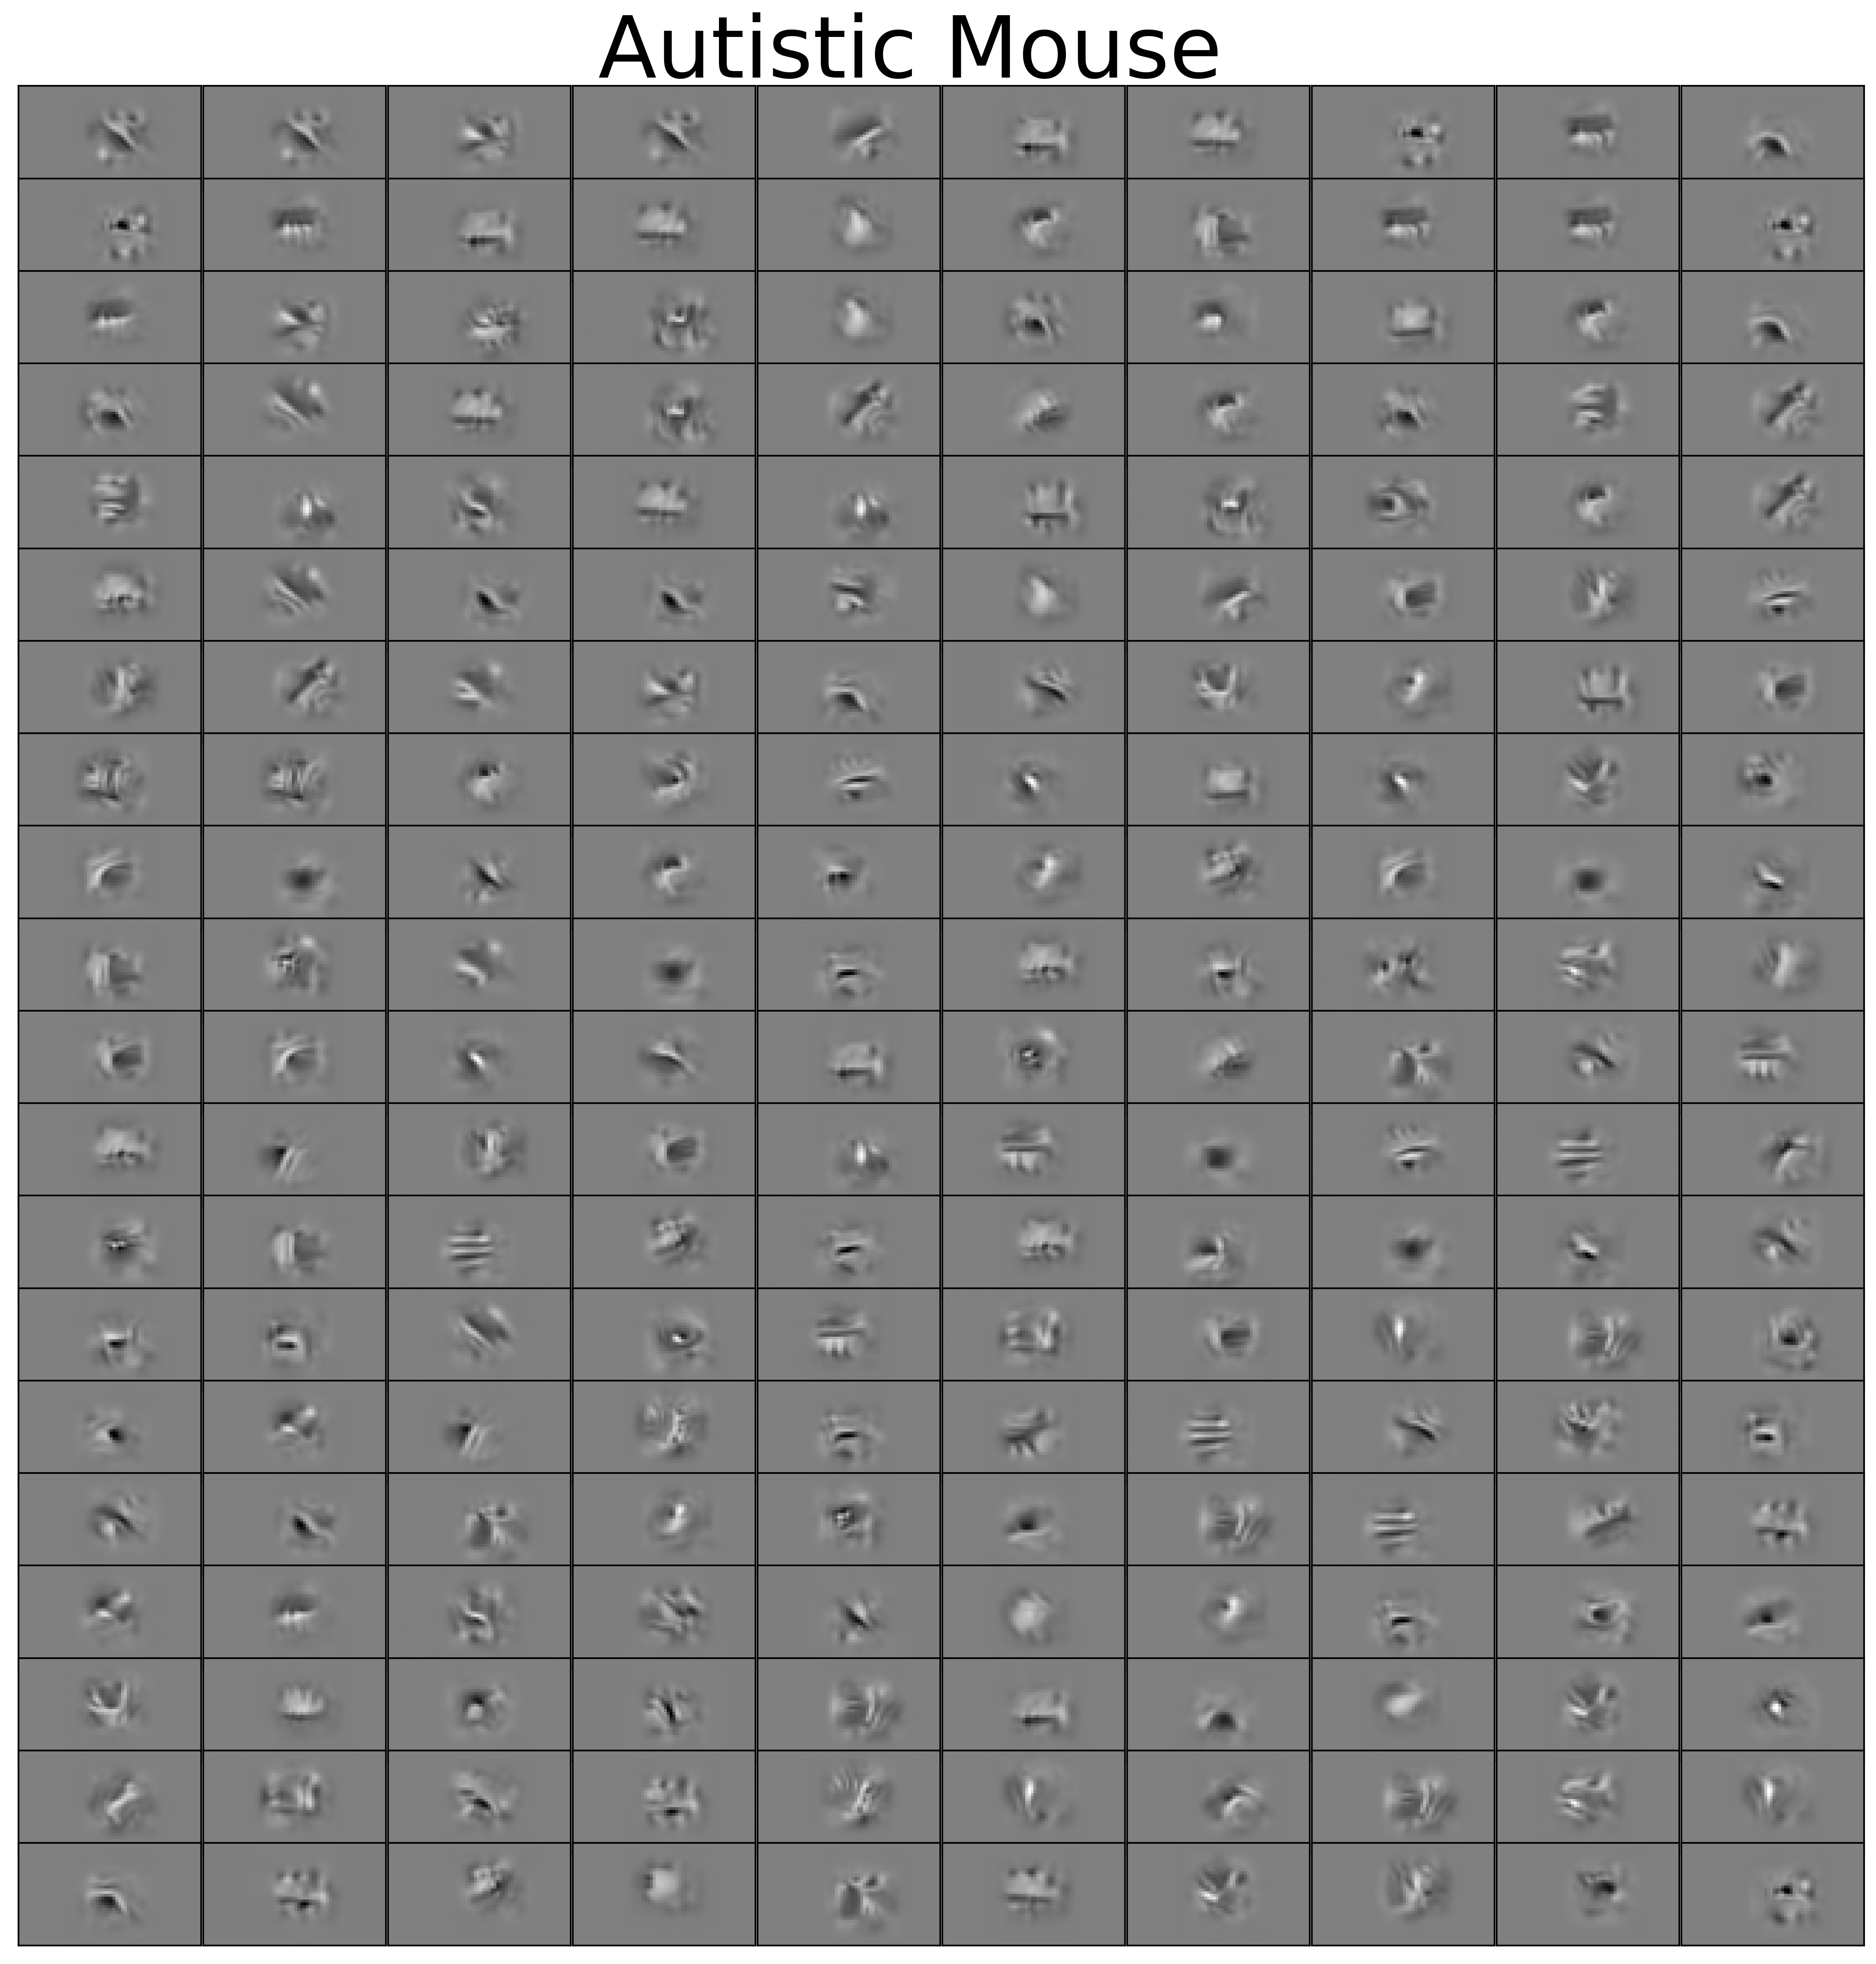

In [14]:
fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
fig.suptitle("Autistic Mouse", y=0.91, fontsize=50)
for i in tqdm(range(20)):
    for j in range(10):
        index = i * 10 + j
        axes[i, j].imshow(meis_a[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
plt.savefig("Plots/AutisticMouseMEIsTop200.png", dpi=300)

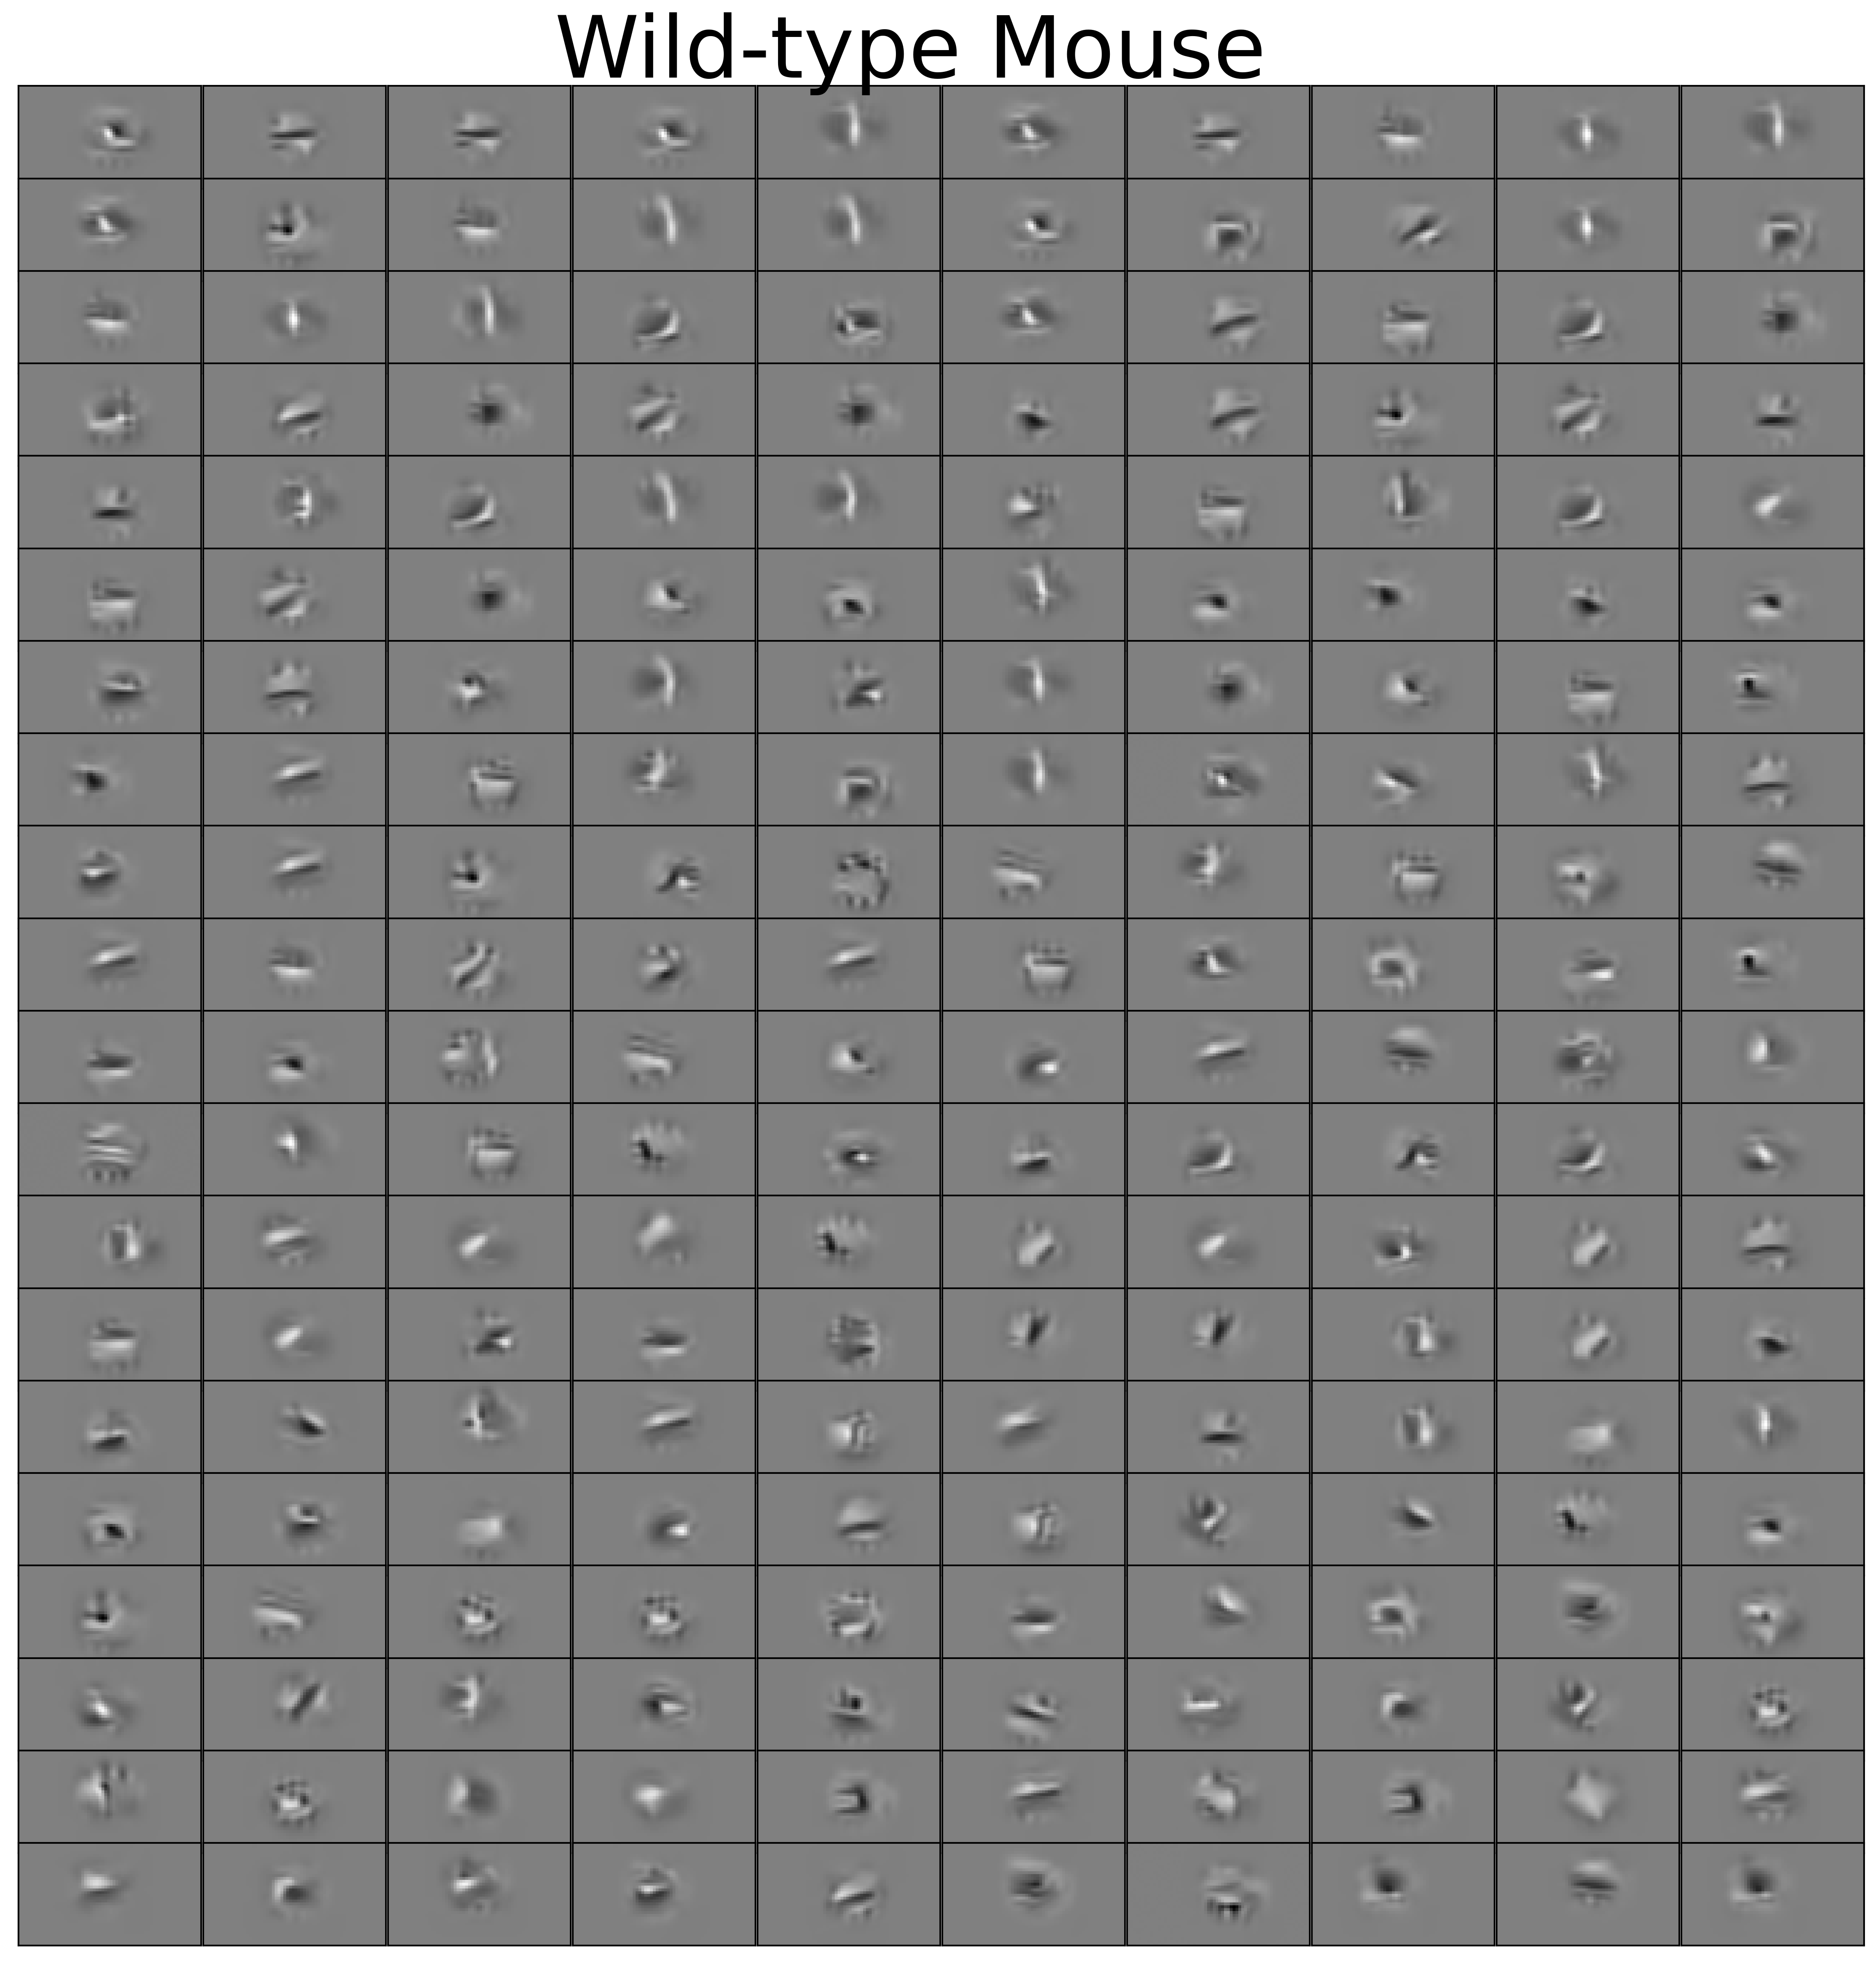

In [16]:
fig, axes = plt.subplots(20,10, figsize=(20,20), dpi=300)
plt.suptitle("Wild-type Mouse", y=0.91, fontsize=50)
for i in range(20):
    for j in range(10):
        index = i * 10 + j
        axes[i, j].imshow(meis_wt[index].reshape(36,64), cmap="gray", vmin=-2, vmax=2)
        axes[i, j].spines['top'].set_color('black')
        axes[i, j].spines['bottom'].set_color('black')
        axes[i, j].spines['left'].set_color('black')
        axes[i, j].spines['right'].set_color('black')
        axes[i, j].spines['top'].set_linewidth(1)
        axes[i, j].spines['bottom'].set_linewidth(1)
        axes[i, j].spines['left'].set_linewidth(1)
        axes[i, j].spines['right'].set_linewidth(1)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
plt.subplots_adjust(wspace=-0.25, hspace=-0.1)
plt.savefig("Plots/WildtypeMouseMEIsTop200.png", dpi=300)